In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from deep_hedging import (
    Underlyings,
    Ticker,
    ConstantRateCurve,
    EuropeanCall,
)
from deep_hedging.hedger import Hedger
from deep_hedging.monte_carlo import GBMSimulator

RANDOM_SEED = 12

In [3]:
N_PATHS = 10_000
N_STOCKS = 1
N_DAYS = 3
RF_RATE = 0.2
STRIKE_LEVEL = 1.0
VOL = 0.2

In [4]:
np.random.seed(RANDOM_SEED)

start = dt.datetime(2019, 1, 1)
end = start + dt.timedelta(days=N_DAYS)

underlyings = Underlyings(
    tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
    start=start,
    end=end,
    dividends=np.array([0.0] * N_STOCKS),
    means=np.array([RF_RATE] * N_STOCKS),
    var_covar=np.array([VOL**2] * N_STOCKS),
)
underlyings.data

In [5]:
curve = ConstantRateCurve(constant_rate=RF_RATE)

In [6]:
european_call = EuropeanCall(
    underlyings=underlyings,
    yield_curve=curve,
    strike_level=STRIKE_LEVEL,
    start_date=start,
    end_date=end,
)

In [7]:
pricer = GBMSimulator(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)

In [8]:
paths = pricer.get_paths(
    spot=[1.0],
    time_till_maturity=N_DAYS / 365,
    risk_free_rate_fn=curve.get_instant_fwd_rate,
    dividends_fn=lambda t: 0.0,
    var_covar_fn=lambda t: np.array([VOL**2] * len(t)),
    n_paths=N_PATHS,
).squeeze(2)
paths.shape

(10000, 4)

In [9]:
hedger = Hedger(european_call, look_ahead=True)

In [18]:
pnl_hedge, pnl_opt = hedger.simulate(
    bids=paths,
    asks=paths,
    rates_lend=curve(european_call.days_till_maturity) / 365,
    rates_borrow=curve(european_call.days_till_maturity) / 365,
)
pnl_hedge.mean(), pnl_opt.mean()

[[1.00054795 1.00109619 1.00164474]
 [1.00054795 1.00109619 1.00164474]
 [1.00054795 1.00109619 1.00164474]
 ...
 [1.00054795 1.00109619 1.00164474]
 [1.00054795 1.00109619 1.00164474]
 [1.00054795 1.00109619 1.00164474]]


(-0.000514505796458699, 0.010043150478230223)

In [235]:
-0.53971893 / 365 * RF_RATE

-0.00029573640000000003

In [20]:
np.exp(0.03 / 365 * 100)

1.0082530482577738

In [236]:
-0.80632745 / 365 * RF_RATE

-0.00044182326027397256

In [237]:
paths[0]

array([1.        , 1.00546339, 0.99880483, 1.00183926, 0.98463475,
       0.99292391, 0.9775711 , 0.97810647, 0.97735789, 0.96960934,
       0.99971527, 0.99396488, 0.99938976, 1.01142877, 0.99912876,
       1.01377796, 1.01298168, 1.02428873, 1.01503095, 1.00463889,
       1.01795435, 1.02382559, 1.02582222, 1.03324103, 1.03947764,
       1.02749082, 1.0044378 , 0.98738496, 0.96954103, 0.94773655,
       0.9417956 , 0.93705954, 0.93713738, 0.93971408, 0.93640038,
       0.93437439, 0.93555352, 0.92628878, 0.919842  , 0.92063783,
       0.91457436, 0.90956084, 0.9090015 , 0.92226621, 0.92580707,
       0.92299445, 0.91780606, 0.91715463, 0.93941169, 0.90939285,
       0.9149567 , 0.91764075, 0.9264762 , 0.91585145, 0.93682508,
       0.94716722, 0.9471248 , 0.94918006, 0.94255019, 0.94351496,
       0.94256464, 0.95239764, 0.95644464, 0.95608091, 0.96336912,
       0.96947569, 0.97222015, 0.95724498, 0.96809918, 0.95681621,
       0.94721828, 0.94664167, 0.95220284, 0.96682586, 0.95035

In [238]:
pnl_hedge

array([-0.38101717, -0.15868814, -0.29871238, ..., -0.25902852,
        0.32268337,  0.28595688])

In [239]:
RF_RATE * european_call.time_till_maturity

0.41479452054794524

In [19]:
(pnl_opt - pnl_hedge).mean() * np.exp(-RF_RATE * european_call.time_till_maturity)

0.01054031547989138

In [241]:
# pnl_hedge_fix, _, _ = hedger.simulate(
#     bids=paths,
#     asks=paths,
#     rates_lend=curve(european_call.days_till_maturity) / 365,
#     rates_borrow=curve(european_call.days_till_maturity) / 365,
#     weights=np.ones(paths.shape) * european_call.delta()
# )

In [242]:
(np.ones(paths.shape) * european_call.delta()).shape

(10000, 758)

In [243]:
paths.shape

(10000, 758)

In [244]:
pnl_opt.std(), pnl_hedge.std(), (pnl_hedge - pnl_opt).std()

(0.42424151565612284, 0.4275846765750382, 0.0065066839046815355)

In [245]:
european_call.price()

array([[0.34731842]])

In [246]:
np.corrcoef(pnl_hedge, pnl_opt)

array([[1.        , 0.99991411],
       [0.99991411, 1.        ]])

In [247]:
(
    pnl_opt - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).mean()

-0.0034736460571188517

In [248]:
(
    pnl_opt - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).std()

0.4242415156561228

In [249]:
(
    pnl_opt
    - pnl_hedge
    - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).std()

0.006506683904681536

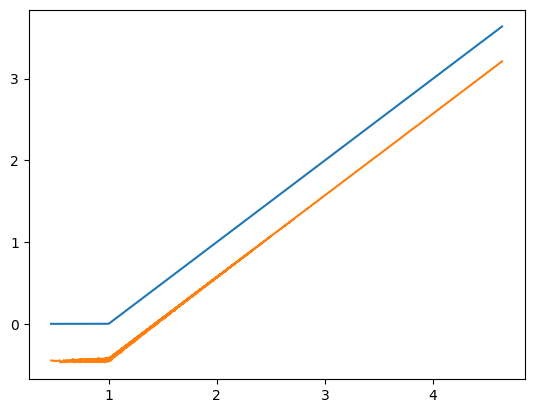

In [250]:
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

In [251]:
(pnl_hedge - RF_RATE * european_call.time_till_maturity).mean()

-0.32473186245162017

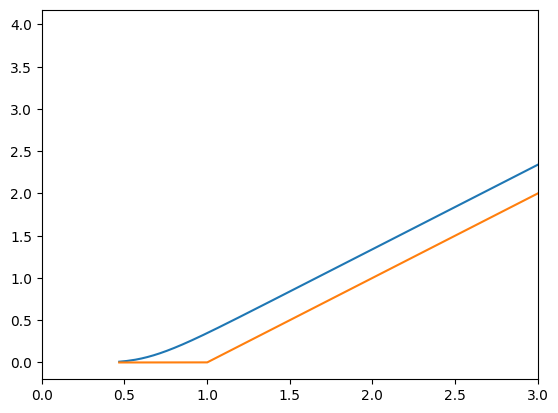

In [252]:
value_opt = european_call.price(spot=paths[:, -1])

plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.xlim([0, 3])
plt.show()

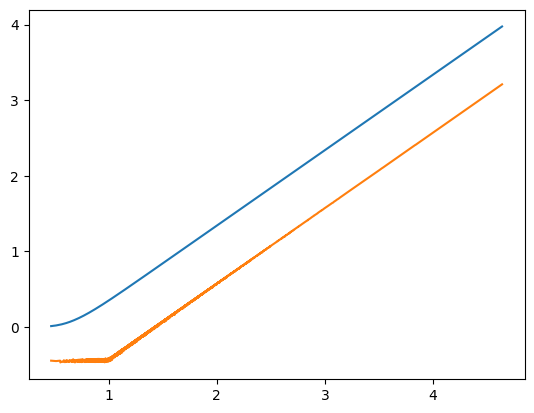

In [253]:
plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

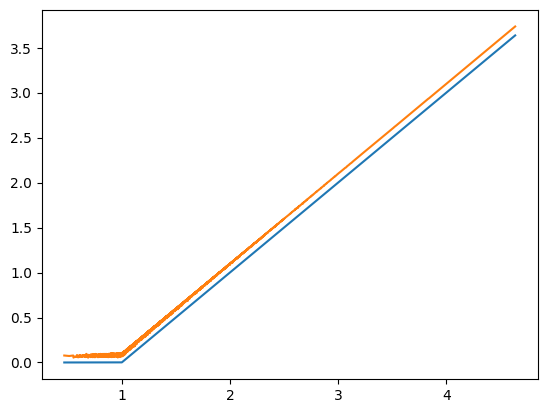

In [254]:
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(
    np.sort(paths[:, -1]),
    pnl_hedge[np.argsort(paths[:, -1])]
    + european_call.price().T.squeeze(1)
    * np.exp(RF_RATE * european_call.time_till_maturity),
)
plt.show()

In [255]:
portfolio = (
    pnl_hedge
    + european_call.price().T.squeeze(1)
    * np.exp(RF_RATE * european_call.time_till_maturity)
    - pnl_opt
)
portfolio.mean(), portfolio.std()

(0.09353630415344391, 0.006506683904681536)

In [256]:
european_call.delta()

array([[0.94341933]])

In [257]:
0.6 * RF_RATE * european_call.time_till_maturity

0.24887671232876712